/home/lgerlac4/cv/CompoundProfiling/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and analyzing features...
=== Feature Statistics for simclr ===
Number of samples: 103
Feature dimension: 2048
Feature range: [0.0000, 18.5258]
Feature mean: 0.0846
Feature std: 0.3237


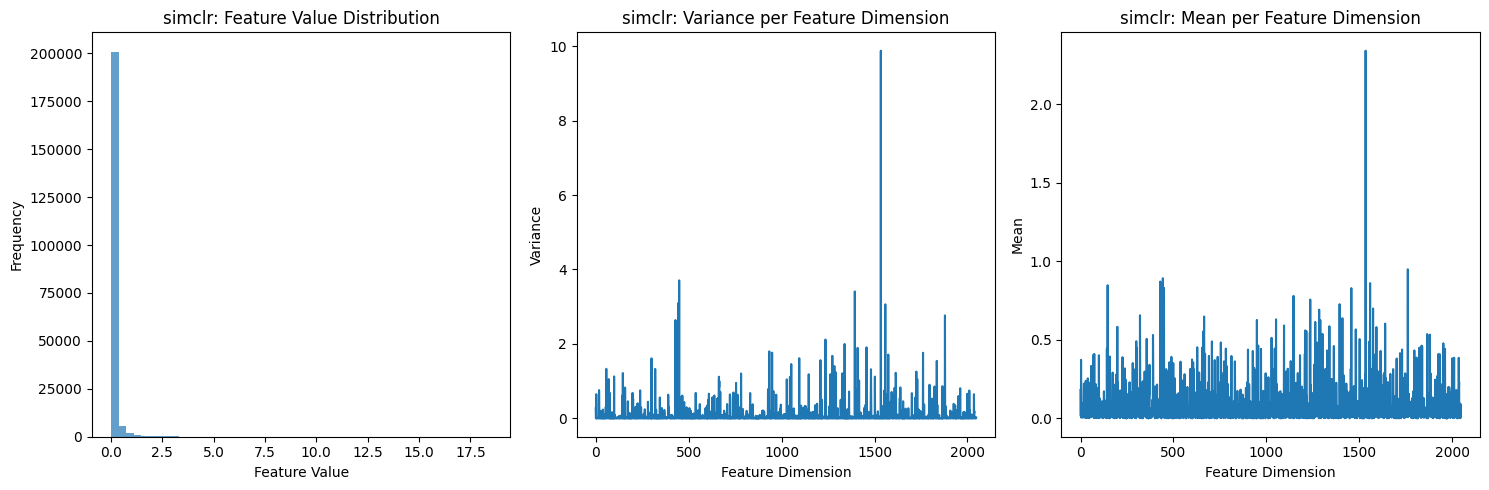


=== Similarity Analysis for simclr ===
Cosine similarity range: [0.0077, 1.0000]
Mean pairwise similarity: 0.2408
Std pairwise similarity: 0.2269
Off-diagonal similarity range: [0.0077, 0.9907]
Off-diagonal mean similarity: 0.2334


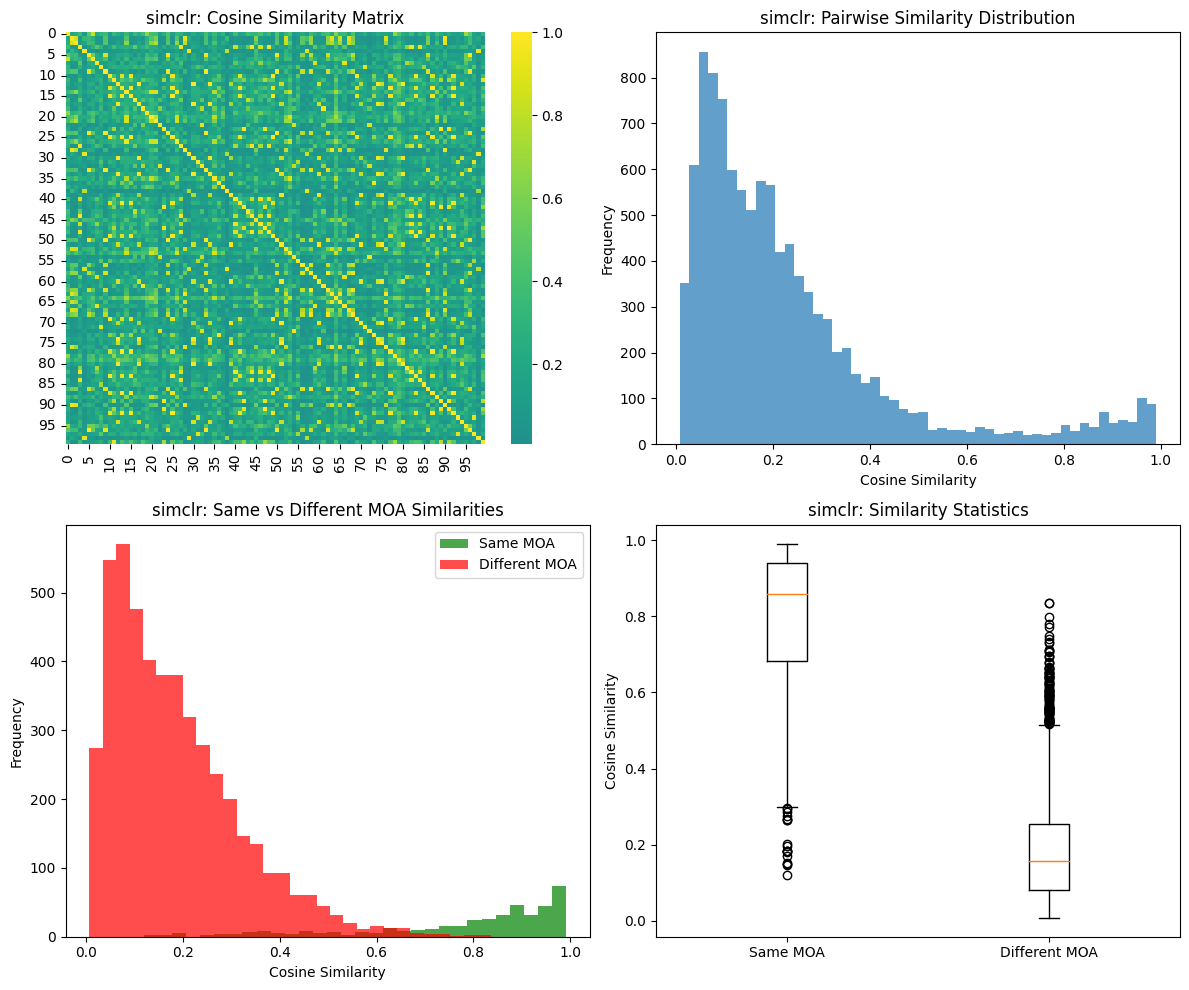


=== 2D Visualization using PCA for simclr ===
PCA explained variance ratio: [0.1902182  0.13328901]
Total explained variance: 0.3235


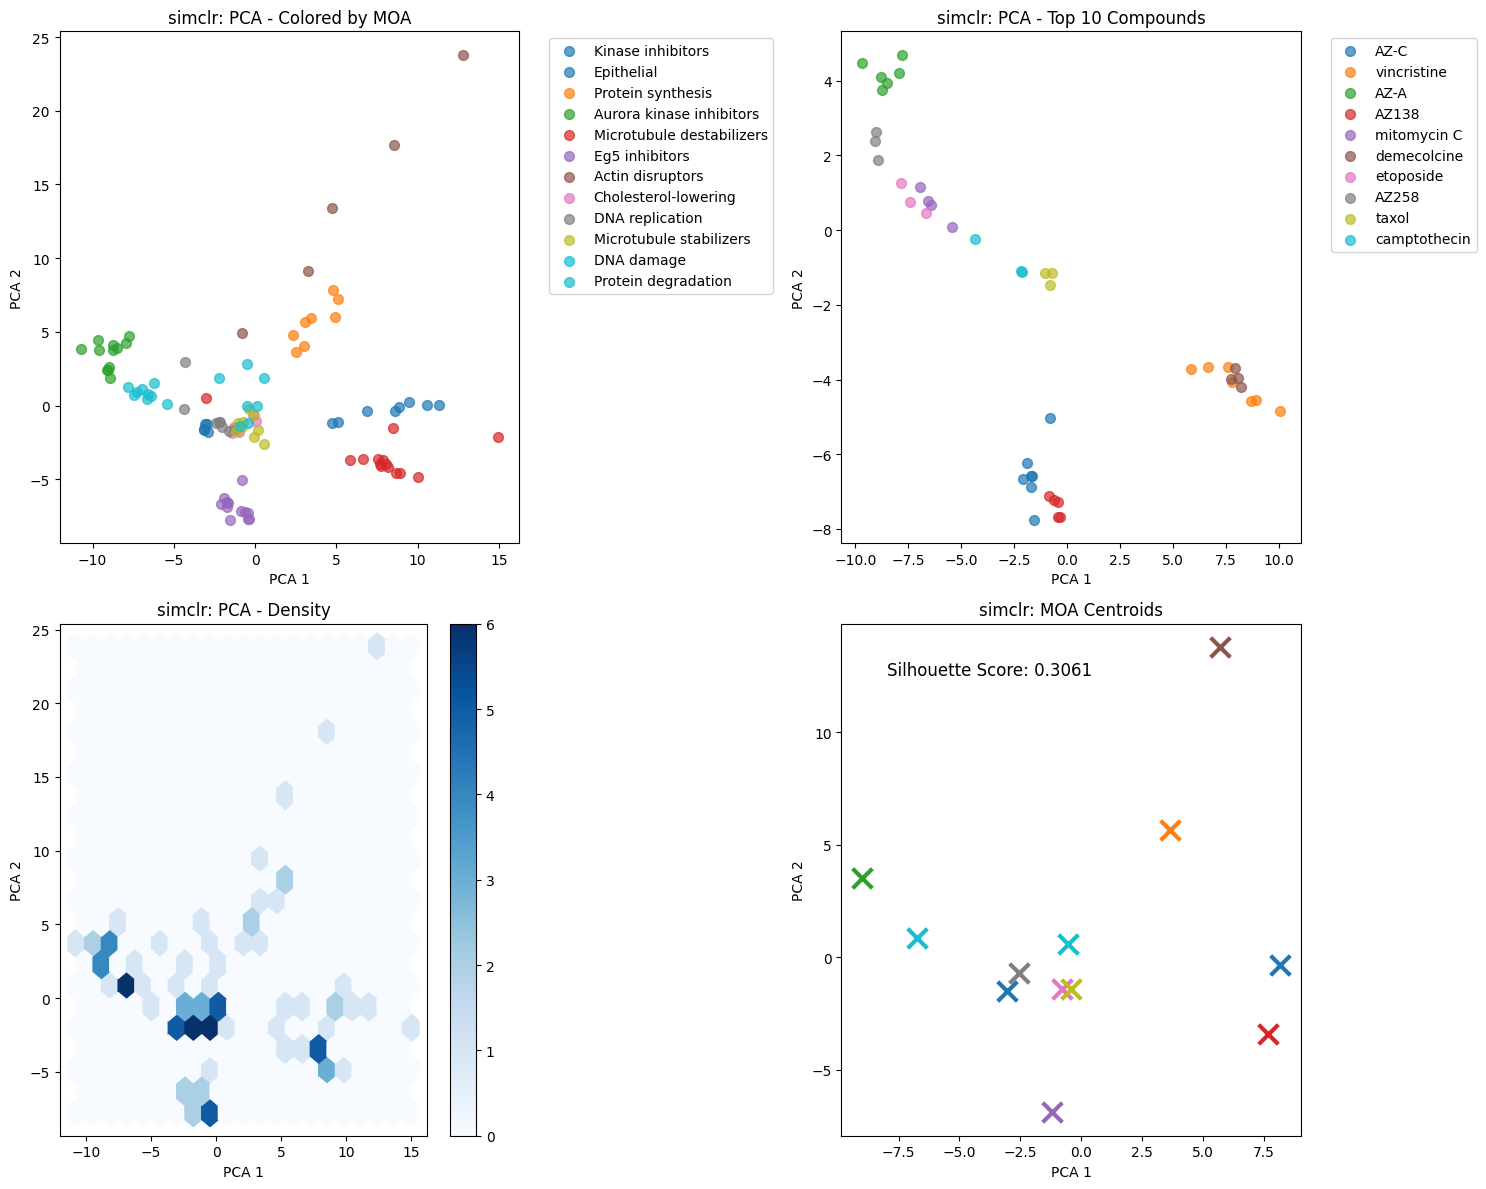

Loaded 103 samples for base_resnet
Loaded 103 samples for simclr

MODEL COMPARISON
=== Feature Statistics for base_resnet ===
Number of samples: 103
Feature dimension: 2048
Feature range: [0.0000, 7.0095]
Feature mean: 0.0666
Feature std: 0.2491


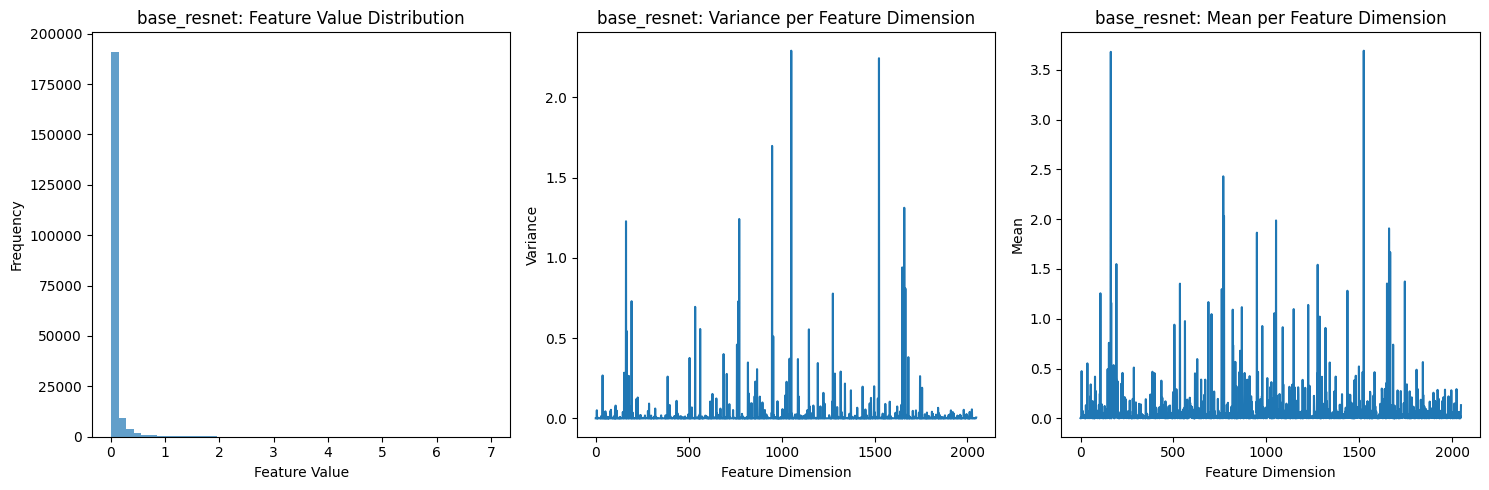

=== Feature Statistics for simclr ===
Number of samples: 103
Feature dimension: 2048
Feature range: [0.0000, 18.5258]
Feature mean: 0.0846
Feature std: 0.3237


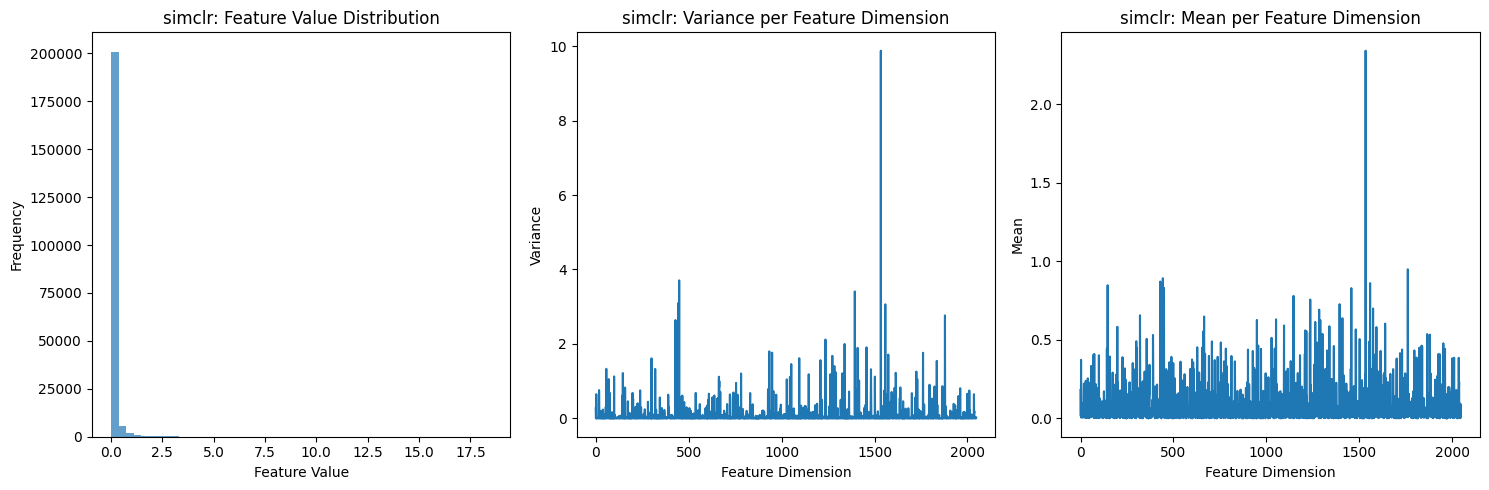


SIMILARITY COMPARISON

=== Similarity Analysis for base_resnet ===
Cosine similarity range: [0.4174, 1.0000]
Mean pairwise similarity: 0.7545
Std pairwise similarity: 0.1138
Off-diagonal similarity range: [0.4174, 0.9923]
Off-diagonal mean similarity: 0.7521


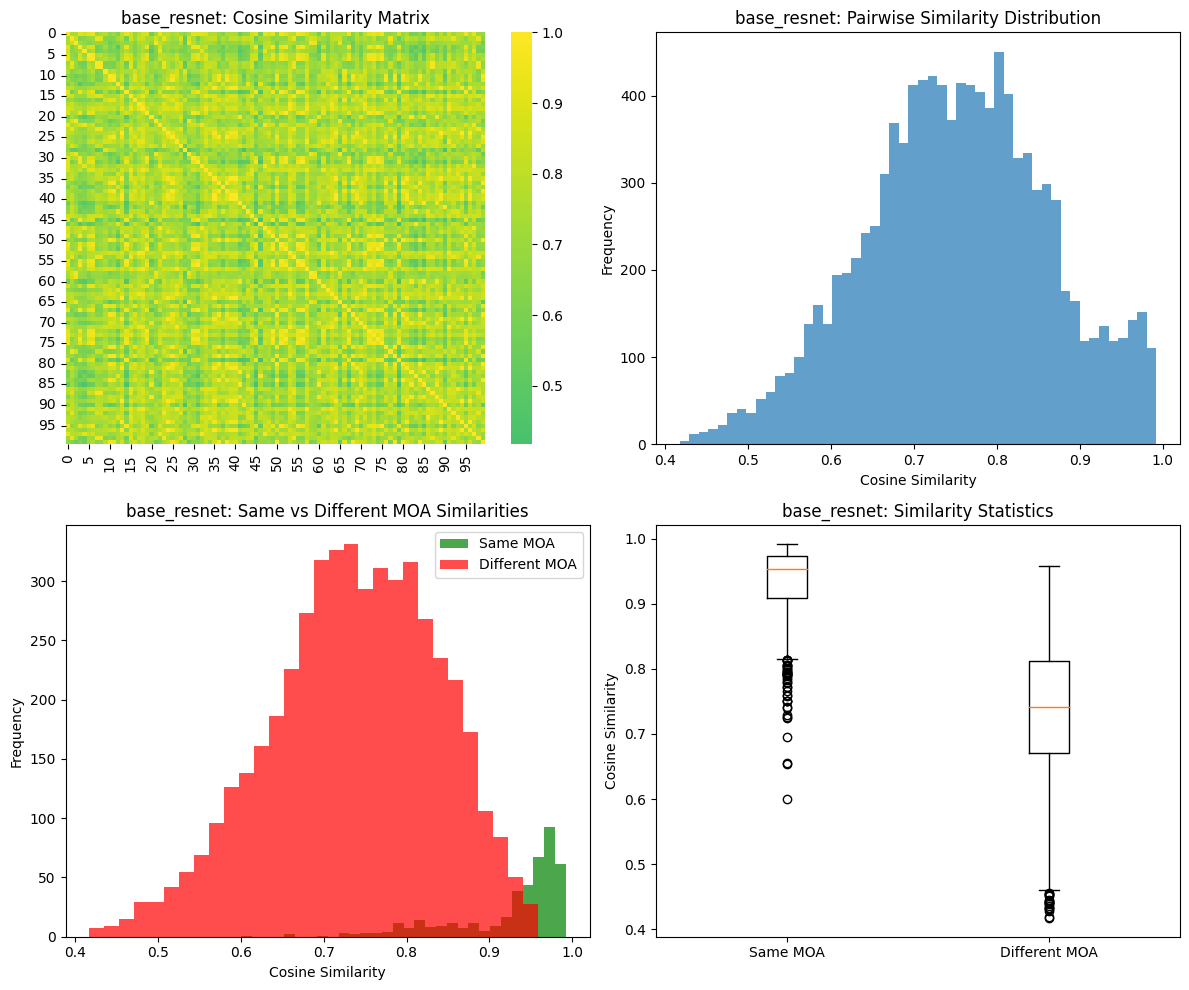


=== Similarity Analysis for simclr ===
Cosine similarity range: [0.0077, 1.0000]
Mean pairwise similarity: 0.2408
Std pairwise similarity: 0.2269
Off-diagonal similarity range: [0.0077, 0.9907]
Off-diagonal mean similarity: 0.2334


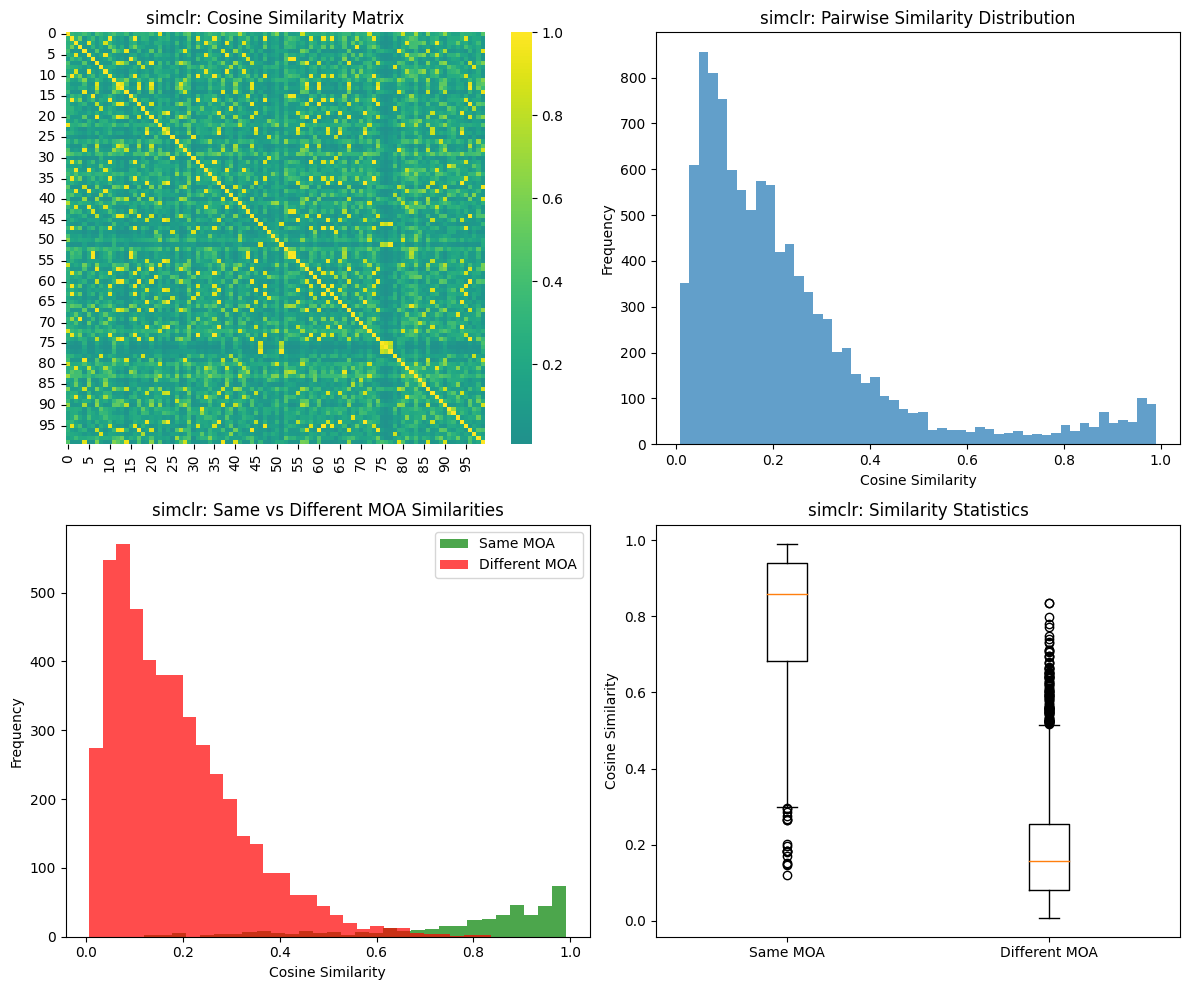


SUMMARY COMPARISON
             Feature Std  Same MOA Similarity  Different MOA Similarity  \
base_resnet     0.249138             0.926203                  0.736396   
simclr          0.323652             0.777948                  0.184201   

             MOA Separation  
base_resnet        0.189807  
simclr             0.593746  


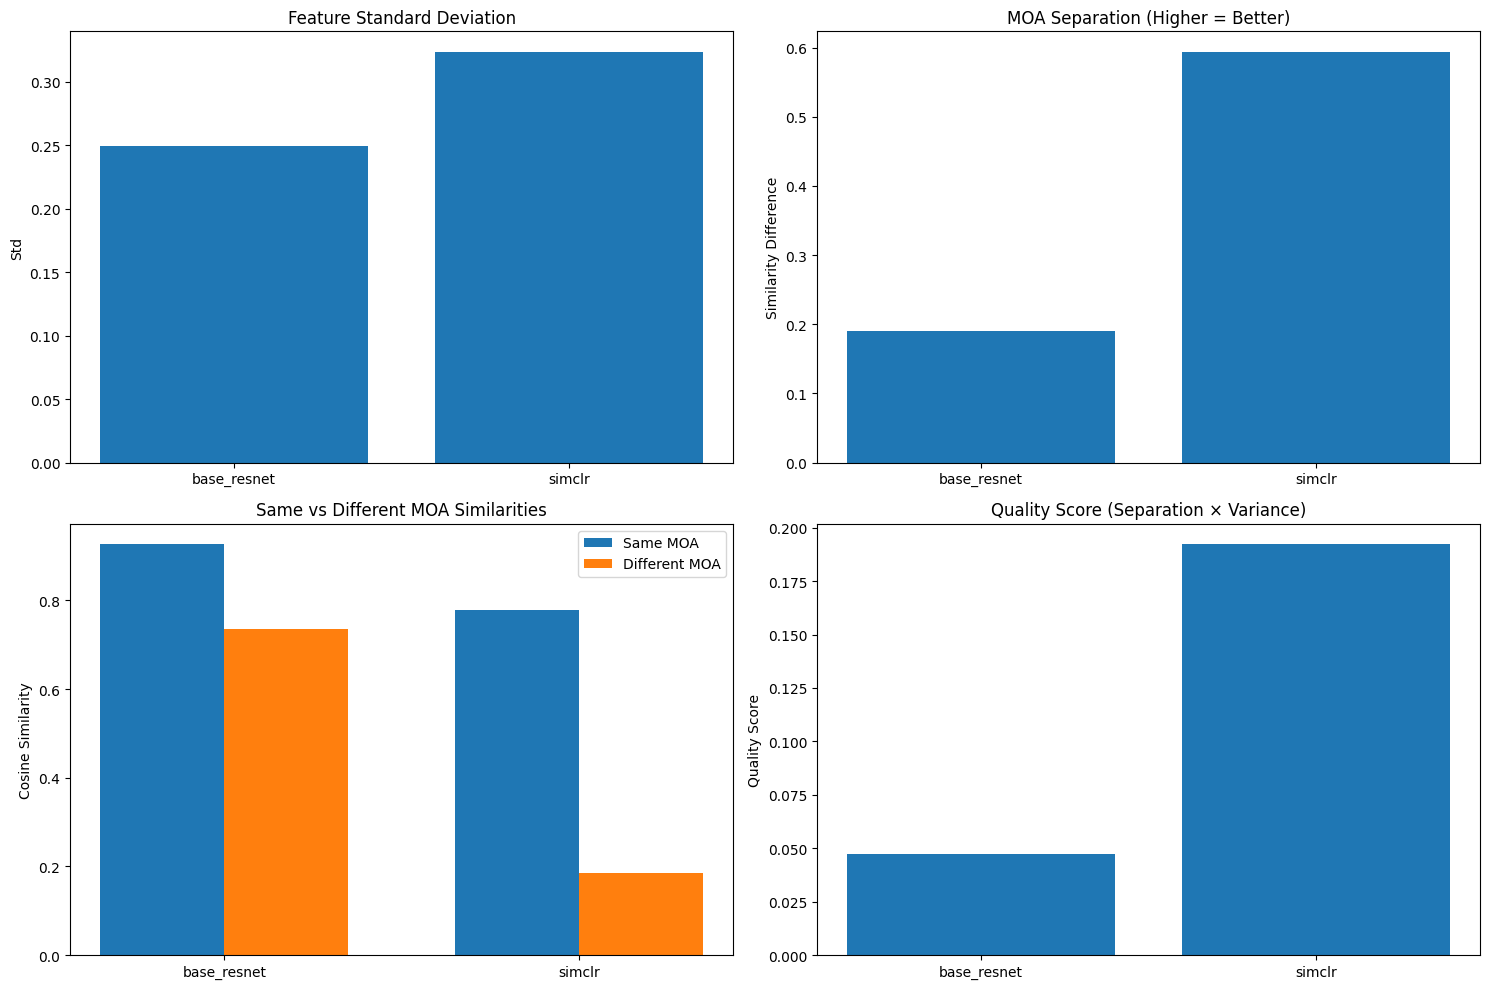

In [1]:
import torch
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from collections import defaultdict, Counter
import pandas as pd
from pybbbc import constants

def load_all_features(model_name, features_dir="/scratch/cv-course2025/group8/bbbc021_features"):
    """Load all features for a given model"""
    model_dir = os.path.join(features_dir, model_name)
    
    features = []
    keys = []
    compounds = []
    moas = []
    concentrations = []
    
    for filename in os.listdir(model_dir):
        if filename.endswith('.pkl'):
            filepath = os.path.join(model_dir, filename)
            try:
                with open(filepath, 'rb') as f:
                    key, feature = pickle.load(f)
                    compound, concentration, moa = key
                    if compound == 'DMSO':
                        continue
                    
                    features.append(feature)
                    keys.append(key)
                    compounds.append(compound)
                    moas.append(moa)
                    concentrations.append(concentration)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")
                continue
    
    features = torch.stack(features) if features else torch.tensor([])
    
    return {
        'features': features,
        'keys': keys,
        'compounds': compounds,
        'moas': moas,
        'concentrations': concentrations
    }

def analyze_feature_statistics(data, model_name):
    """Analyze basic statistics of features"""
    features = data['features']
    
    print(f"=== Feature Statistics for {model_name} ===")
    print(f"Number of samples: {len(features)}")
    print(f"Feature dimension: {features.shape[1] if len(features) > 0 else 0}")
    print(f"Feature range: [{features.min():.4f}, {features.max():.4f}]")
    print(f"Feature mean: {features.mean():.4f}")
    print(f"Feature std: {features.std():.4f}")
    
    # Check for potential issues
    if features.std() < 0.01:
        print("⚠️ WARNING: Very low feature variance - possible feature collapse!")
    
    if torch.isnan(features).any():
        print("⚠️ WARNING: NaN values detected in features!")
    
    if torch.isinf(features).any():
        print("⚠️ WARNING: Infinite values detected in features!")
    
    # Analyze feature distribution
    plt.figure(figsize=(15, 5))
    
    # Feature value distribution
    plt.subplot(1, 3, 1)
    plt.hist(features.flatten().numpy(), bins=50, alpha=0.7)
    plt.title(f'{model_name}: Feature Value Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    
    # Feature variance per dimension
    plt.subplot(1, 3, 2)
    feature_vars = features.var(dim=0)
    plt.plot(feature_vars.numpy())
    plt.title(f'{model_name}: Variance per Feature Dimension')
    plt.xlabel('Feature Dimension')
    plt.ylabel('Variance')
    
    # Feature mean per dimension
    plt.subplot(1, 3, 3)
    feature_means = features.mean(dim=0)
    plt.plot(feature_means.numpy())
    plt.title(f'{model_name}: Mean per Feature Dimension')
    plt.xlabel('Feature Dimension')
    plt.ylabel('Mean')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mean': features.mean().item(),
        'std': features.std().item(),
        'min': features.min().item(),
        'max': features.max().item(),
        'variance_per_dim': feature_vars,
        'mean_per_dim': feature_means
    }

def analyze_feature_similarities(data, model_name):
    """Analyze pairwise similarities between features"""
    features = data['features']
    moas = data['moas']
    
    # Normalize features for cosine similarity
    features_norm = torch.nn.functional.normalize(features, p=2, dim=1)
    
    # Compute pairwise cosine similarities
    similarity_matrix = torch.mm(features_norm, features_norm.t())
    
    print(f"\n=== Similarity Analysis for {model_name} ===")
    print(f"Cosine similarity range: [{similarity_matrix.min():.4f}, {similarity_matrix.max():.4f}]")
    print(f"Mean pairwise similarity: {similarity_matrix.mean():.4f}")
    print(f"Std pairwise similarity: {similarity_matrix.std():.4f}")
    
    # Remove diagonal (self-similarities)
    mask = torch.eye(similarity_matrix.size(0), dtype=torch.bool)
    off_diagonal_sims = similarity_matrix[~mask]
    
    print(f"Off-diagonal similarity range: [{off_diagonal_sims.min():.4f}, {off_diagonal_sims.max():.4f}]")
    print(f"Off-diagonal mean similarity: {off_diagonal_sims.mean():.4f}")
    
    # Check for potential feature collapse
    if off_diagonal_sims.mean() > 0.9:
        print("⚠️ WARNING: Very high average similarity - possible feature collapse!")
    
    # Visualize similarity matrix
    plt.figure(figsize=(12, 10))
    
    # Full similarity matrix (subsampled if too large)
    max_samples = 100
    if len(features) > max_samples:
        indices = np.random.choice(len(features), max_samples, replace=False)
        sub_similarity = similarity_matrix[indices][:, indices]
        sub_moas = [moas[i] for i in indices]
    else:
        sub_similarity = similarity_matrix
        sub_moas = moas
    
    plt.subplot(2, 2, 1)
    sns.heatmap(sub_similarity.numpy(), cmap='viridis', center=0)
    plt.title(f'{model_name}: Cosine Similarity Matrix')
    
    # Similarity distribution
    plt.subplot(2, 2, 2)
    plt.hist(off_diagonal_sims.numpy(), bins=50, alpha=0.7)
    plt.title(f'{model_name}: Pairwise Similarity Distribution')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    
    # Same MOA vs Different MOA similarities
    same_moa_sims = []
    diff_moa_sims = []
    
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            sim = similarity_matrix[i, j].item()
            if moas[i] == moas[j]:
                same_moa_sims.append(sim)
            else:
                diff_moa_sims.append(sim)
    
    plt.subplot(2, 2, 3)
    plt.hist(same_moa_sims, bins=30, alpha=0.7, label='Same MOA', color='green')
    plt.hist(diff_moa_sims, bins=30, alpha=0.7, label='Different MOA', color='red')
    plt.title(f'{model_name}: Same vs Different MOA Similarities')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Summary statistics
    plt.subplot(2, 2, 4)
    stats_data = [same_moa_sims, diff_moa_sims]
    labels = ['Same MOA', 'Different MOA']
    plt.boxplot(stats_data, labels=labels)
    plt.title(f'{model_name}: Similarity Statistics')
    plt.ylabel('Cosine Similarity')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'same_moa_mean': np.mean(same_moa_sims),
        'diff_moa_mean': np.mean(diff_moa_sims),
        'separation': np.mean(same_moa_sims) - np.mean(diff_moa_sims)
    }

def visualize_feature_embeddings(data, model_name, method='pca'):
    """Visualize features in 2D using dimensionality reduction"""
    features = data['features'].numpy()
    moas = data['moas']
    compounds = data['compounds']
    
    print(f"\n=== 2D Visualization using {method.upper()} for {model_name} ===")
    
    # Apply dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        embedding = reducer.fit_transform(features)
        print(f"PCA explained variance ratio: {reducer.explained_variance_ratio_}")
        print(f"Total explained variance: {reducer.explained_variance_ratio_.sum():.4f}")
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
        embedding = reducer.fit_transform(features)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
        embedding = reducer.fit_transform(features)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Create color map for MOAs
    unique_moas = list(set(moas))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_moas)))
    moa_colors = {moa: colors[i] for i, moa in enumerate(unique_moas)}
    
    plt.figure(figsize=(15, 12))
    
    # Plot by MOA
    plt.subplot(2, 2, 1)
    for moa in unique_moas:
        mask = [m == moa for m in moas]
        plt.scatter(embedding[mask, 0], embedding[mask, 1], 
                   c=[moa_colors[moa]], label=moa, alpha=0.7, s=50)
    plt.title(f'{model_name}: {method.upper()} - Colored by MOA')
    plt.xlabel(f'{method.upper()} 1')
    plt.ylabel(f'{method.upper()} 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot by compound (top 10 most frequent)
    plt.subplot(2, 2, 2)
    compound_counts = Counter(compounds)
    top_compounds = [comp for comp, _ in compound_counts.most_common(10)]
    
    for i, compound in enumerate(top_compounds):
        mask = [c == compound for c in compounds]
        if any(mask):
            plt.scatter(embedding[mask, 0], embedding[mask, 1], 
                       label=compound, alpha=0.7, s=50)
    plt.title(f'{model_name}: {method.upper()} - Top 10 Compounds')
    plt.xlabel(f'{method.upper()} 1')
    plt.ylabel(f'{method.upper()} 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Density plot
    plt.subplot(2, 2, 3)
    plt.hexbin(embedding[:, 0], embedding[:, 1], gridsize=20, cmap='Blues')
    plt.title(f'{model_name}: {method.upper()} - Density')
    plt.xlabel(f'{method.upper()} 1')
    plt.ylabel(f'{method.upper()} 2')
    plt.colorbar()
    
    # MOA separation quality
    plt.subplot(2, 2, 4)
    # Calculate silhouette-like score for MOA separation
    from sklearn.metrics import silhouette_score
    moa_labels = [unique_moas.index(moa) for moa in moas]
    if len(set(moa_labels)) > 1:
        silhouette = silhouette_score(embedding, moa_labels)
        plt.text(0.1, 0.9, f'Silhouette Score: {silhouette:.4f}', 
                transform=plt.gca().transAxes, fontsize=12)
        
        # Show MOA centroids
        centroids = {}
        for moa in unique_moas:
            mask = [m == moa for m in moas]
            centroid = embedding[mask].mean(axis=0)
            centroids[moa] = centroid
            plt.scatter(*centroid, c=[moa_colors[moa]], s=200, marker='x', linewidth=3)
        
        plt.title(f'{model_name}: MOA Centroids')
        plt.xlabel(f'{method.upper()} 1')
        plt.ylabel(f'{method.upper()} 2')
    
    plt.tight_layout()
    plt.show()
    
    return embedding

def compare_models(model_names=['base_resnet', 'simclr']):
    """Compare multiple models"""
    model_data = {}
    
    # Load data for all models
    for model_name in model_names:
        try:
            model_data[model_name] = load_all_features(model_name)
            print(f"Loaded {len(model_data[model_name]['features'])} samples for {model_name}")
        except Exception as e:
            print(f"Error loading {model_name}: {e}")
            continue
    
    if len(model_data) < 2:
        print("Need at least 2 models to compare")
        return
    
    # Compare statistics
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    
    stats = {}
    for model_name, data in model_data.items():
        stats[model_name] = analyze_feature_statistics(data, model_name)
    
    # Compare similarities
    print("\n" + "="*30)
    print("SIMILARITY COMPARISON")
    print("="*30)
    
    similarity_stats = {}
    for model_name, data in model_data.items():
        similarity_stats[model_name] = analyze_feature_similarities(data, model_name)
    
    # Summary comparison
    print("\n" + "="*30)
    print("SUMMARY COMPARISON")
    print("="*30)
    
    comparison_df = pd.DataFrame({
        model: {
            'Feature Std': stats[model]['std'],
            'Same MOA Similarity': similarity_stats[model]['same_moa_mean'],
            'Different MOA Similarity': similarity_stats[model]['diff_moa_mean'],
            'MOA Separation': similarity_stats[model]['separation']
        }
        for model in model_data.keys()
    }).T
    
    print(comparison_df)
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Feature standard deviation
    models = list(comparison_df.index)
    axes[0,0].bar(models, comparison_df['Feature Std'])
    axes[0,0].set_title('Feature Standard Deviation')
    axes[0,0].set_ylabel('Std')
    
    # MOA separation
    axes[0,1].bar(models, comparison_df['MOA Separation'])
    axes[0,1].set_title('MOA Separation (Higher = Better)')
    axes[0,1].set_ylabel('Similarity Difference')
    
    # Same vs Different MOA similarities
    x = np.arange(len(models))
    width = 0.35
    axes[1,0].bar(x - width/2, comparison_df['Same MOA Similarity'], width, label='Same MOA')
    axes[1,0].bar(x + width/2, comparison_df['Different MOA Similarity'], width, label='Different MOA')
    axes[1,0].set_title('Same vs Different MOA Similarities')
    axes[1,0].set_ylabel('Cosine Similarity')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(models)
    axes[1,0].legend()
    
    # Overall quality score
    quality_score = comparison_df['MOA Separation'] * comparison_df['Feature Std']
    axes[1,1].bar(models, quality_score)
    axes[1,1].set_title('Quality Score (Separation × Variance)')
    axes[1,1].set_ylabel('Quality Score')
    
    plt.tight_layout()
    plt.show()
    
    return model_data, comparison_df

# Beispiel-Nutzung:
print("Loading and analyzing features...")

# Einzelne Modell-Analyse
simclr_data = load_all_features('simclr')
simclr_stats = analyze_feature_statistics(simclr_data, 'simclr')
simclr_sim_stats = analyze_feature_similarities(simclr_data, 'simclr')

# 2D Visualisierung
embedding = visualize_feature_embeddings(simclr_data, 'simclr', method='pca')

# Modell-Vergleich
model_data, comparison = compare_models(['base_resnet', 'simclr'])